In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [55]:
data=pd.read_csv("Data/data.csv",
                 usecols=['Date', 'open', 'high', 'low', 'close', 'vol'],
                 parse_dates=['Date'],
                 index_col=['Date'],)
data.head(10)

,open,high,low,close,vol
Date,,,,,
2012-01-01,873.0,879.0,851.0,879.0,799
2012-01-02,879.0,913.0,882.0,900.0,1002
2012-01-03,900.0,916.0,892.0,892.0,2653
2012-01-04,892.0,875.0,842.0,865.0,490
2012-01-05,865.0,875.0,858.0,858.0,121
2012-01-08,858.0,845.0,814.0,830.0,4835
2012-01-09,830.0,846.0,830.0,846.0,195
2012-01-10,858.0,862.0,845.0,845.0,658
2012-01-11,845.0,874.0,845.0,874.0,969


In [56]:
data.isnull().sum() #checking for nullity

open     0
high     0
low      0
close    0
vol      0
dtype: int64

In [57]:
def plot_graph(record):      # reusale function for plotting purposes
    plt.figure(figsize=(20,12))
    plt.plot(record)

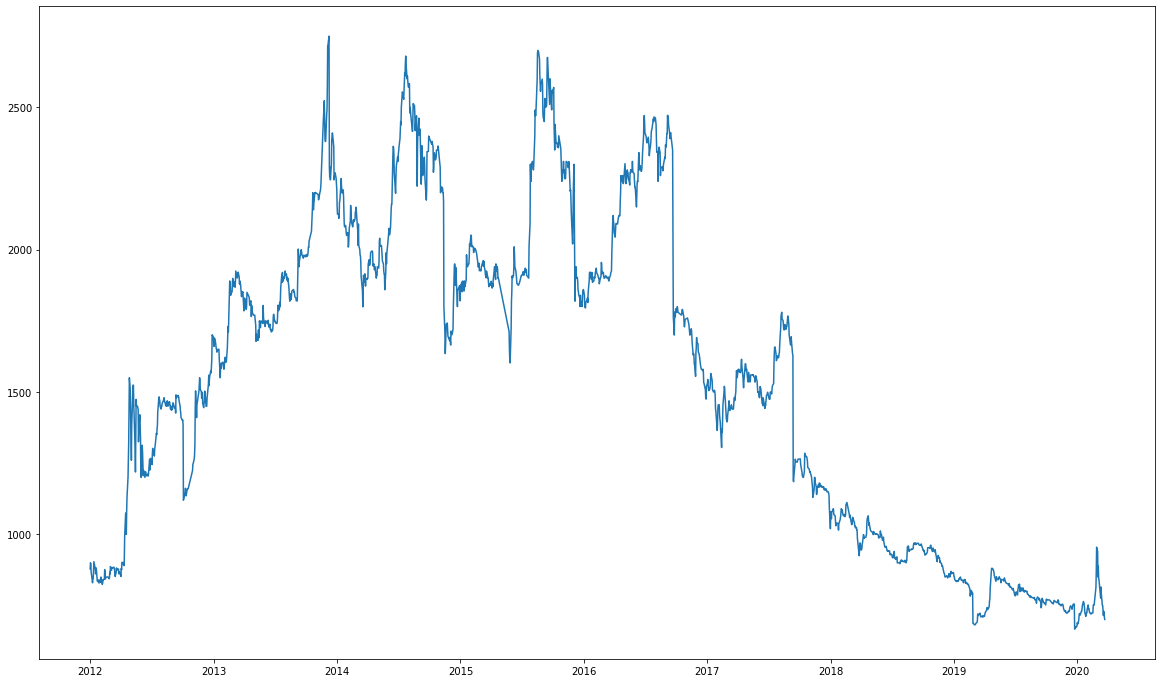

In [58]:
plot_graph(data.close)

In [59]:
data=data[['close']]
data.tail()

,close
Date,
2020-03-16,750.0
2020-03-17,731.0
2020-03-18,715.0
2020-03-19,730.0
2020-03-22,701.0


In [60]:
data.close=data.close.resample("W").mean()  #smoothing the data by resampling it in week period
data.dropna(inplace=True)
data.head(10)

,close
Date,
2012-01-01,879.000000
2012-01-08,869.000000
2012-01-22,864.500000
2012-01-29,833.750000
2012-02-05,838.250000
2012-02-12,835.600000
2012-02-26,848.000000
2012-03-04,867.200000
2012-03-11,883.333333


### The curve is smoother than the previous one

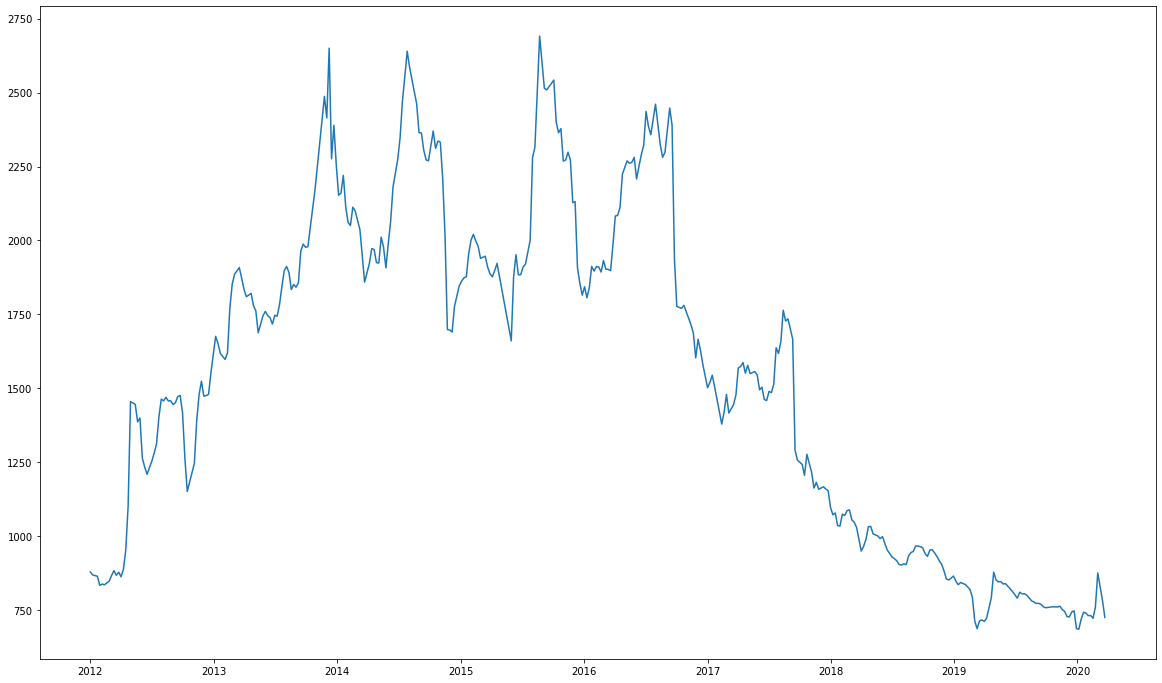

In [61]:
plot_graph(data.close) 

## Cheking for stationarity of time series

In [62]:
from statsmodels.tsa.stattools import adfuller

#Ho: It is not stationary
#H1: It is stationary

def adfuller_test(records):
    result=adfuller(records)
    labels=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for label,value in zip(labels,result):
        print(label+" : "+str(value))
    if result[1]<=0.05:
        print("Null hypothesis is rejected. Series is stationary.")
    else:
        print("Null hypothesis is accepted. Series in not stationary.")

In [63]:
adfuller_test(data.close)

ADF Test Statistic : -1.5935367271274512
p-value : 0.48683941293703936
#Lags Used : 2
Number of Observations Used : 376
Null hypothesis is accepted. Series in not stationary.


In [64]:
first_difference=data['close']-data['close'].shift(1)

In [65]:
adfuller_test(first_difference.dropna())

ADF Test Statistic : -11.510902375472913
p-value : 4.2623680183828935e-21
#Lags Used : 1
Number of Observations Used : 376
Null hypothesis is rejected. Series is stationary.


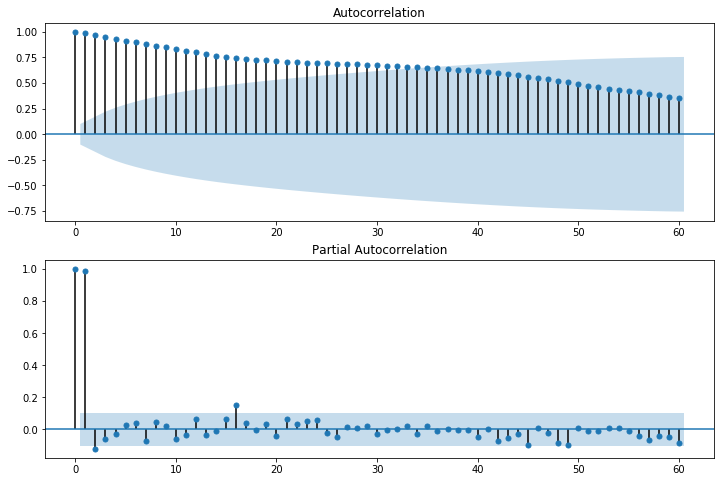

In [66]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['close'].dropna(),lags=60,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['close'].dropna(),lags=60,ax=ax2)

In [95]:
from statsmodels.tsa.arima_model import ARIMA

model=ARIMA(data['close'],order=(10,1,0))
model_fit=model.fit(disp=0)
print(model_fit.summary())

/home/bishesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bishesh/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  378
Model:                ARIMA(10, 1, 0)   Log Likelihood               -2164.964
Method:                       css-mle   S.D. of innovations             74.308
Date:                Wed, 26 Aug 2020   AIC                           4353.928
Time:                        19:22:20   BIC                           4401.147
Sample:                             1   HQIC                          4372.669
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.4689      4.521     -0.104      0.917      -9.330       8.393
ar.L1.D.close      0.1478      0.051      2.877      0.004       0.047       0.249
ar.L2.D.close      0.1040      0.052

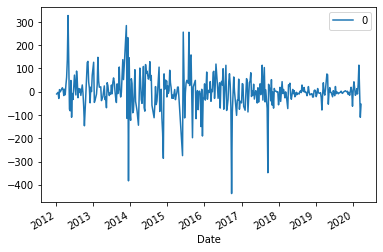

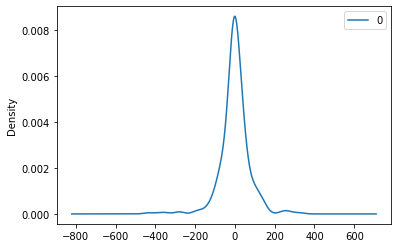

In [96]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

In [97]:
residuals.describe()

,0
count,378.000000
mean,-0.000786
std,74.407249
min,-437.520116
25%,-25.317204
50%,-0.977912
75%,30.599171
max,327.571402


In [98]:
X=data.close.values
len(X)

379

In [99]:
size = int(len(X) * 0.66)  #splitting of data into train and test set
train, test = X[0:size], X[size:len(X)]
actual_train = [x for x in train]
predictions=list()

In [100]:
for t in range(len(test)):
    model = ARIMA(actual_train, order=(10,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    prediction = output[0]
    predictions.append(prediction)
    test_value = test[t]
    actual_train.append(test_value)
    print('%d. predicted=%f, expected=%f'%(t+1,prediction,test_value))

1. predicted=1523.594928, expected=1637.200000
2. predicted=1658.792818, expected=1617.800000
3. predicted=1625.983827, expected=1658.000000
4. predicted=1660.406269, expected=1764.000000
5. predicted=1778.624967, expected=1727.500000
6. predicted=1728.884650, expected=1735.000000
7. predicted=1741.155576, expected=1667.000000
8. predicted=1647.886697, expected=1291.200000
9. predicted=1221.487158, expected=1257.333333
10. predicted=1233.396378, expected=1242.666667
11. predicted=1247.304331, expected=1205.800000
12. predicted=1225.428732, expected=1276.750000
13. predicted=1310.694417, expected=1246.750000
14. predicted=1218.200806, expected=1216.400000
15. predicted=1239.234711, expected=1162.800000
16. predicted=1168.536390, expected=1182.200000
17. predicted=1154.307874, expected=1158.400000
18. predicted=1168.792048, expected=1167.000000
19. predicted=1163.287412, expected=1159.600000
20. predicted=1154.895958, expected=1153.800000
21. predicted=1154.930586, expected=1097.250000
2

In [101]:
from sklearn.metrics import mean_squared_error
import math

error=mean_squared_error(test,predictions)
rmse=math.sqrt(error)
print(f'The mean squared error is {error}')
print(f'The rmse is {rmse}')

The mean squared error is 2048.0394111861006
The rmse is 45.25526943004649


In [102]:
rng=data.iloc[250:,:].index
pred=pd.DataFrame(data=predictions,index=rng,columns=['prediction'])
print(data.shape)
print(len(test))

(379, 1)
129


In [103]:
data.iloc[250:,:].index

DatetimeIndex(['2017-07-23', '2017-07-30', '2017-08-06', '2017-08-13',
               '2017-08-20', '2017-08-27', '2017-09-10', '2017-09-17',
               '2017-09-24', '2017-10-08',
               ...
               '2020-01-12', '2020-01-19', '2020-01-26', '2020-02-02',
               '2020-02-09', '2020-02-16', '2020-02-23', '2020-03-01',
               '2020-03-15', '2020-03-22'],
              dtype='datetime64[ns]', name='Date', length=129, freq=None)

## The model worked well in test data

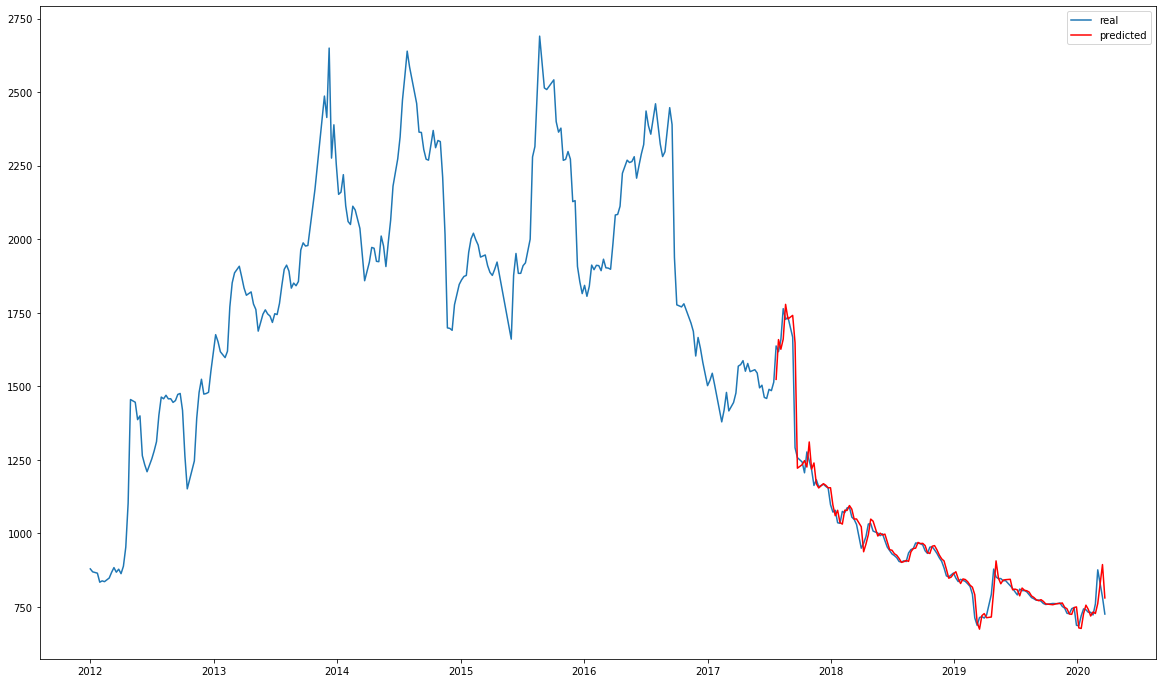

In [104]:
plt.figure(figsize=(20,12))
plt.plot(data,label="real")
plt.plot(pred,color='red',label='predicted')
plt.legend()

## Forecasting closing price for next 20 weeks.
It is to be kept in mind that as we keep moving in forecasting period(towards the end of 20 weeks period), the       uncertainity in the prediction increases.

I have implemented 2 methods of forecasting:<br/>
* using forecast() function of ARIMA. <br/>
* training ARIMA again for next 20 weeks, appending the predicted value in training list.

In [105]:
forecast_20=model_fit.forecast(steps=20)

In [106]:
rng_20=pd.date_range(start="2020-03-23",end="2020-08-12",freq='W')
len(rng_20)

20

In [107]:
rng_20

DatetimeIndex(['2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09'],
              dtype='datetime64[ns]', freq='W-SUN')

In [114]:
forecast=pd.DataFrame(data=forecast_20[0],index=rng_20,columns=['forecast'])
forecast.head(10)

,forecast
2020-03-29,780.270461
2020-04-05,765.316043
2020-04-12,757.753409
2020-04-19,759.044149
2020-04-26,773.410709
2020-05-03,756.657515
2020-05-10,758.124697
2020-05-17,766.940970
2020-05-24,764.681769
2020-05-31,765.228530


In [109]:
from tqdm import tqdm

## Method 2

In [110]:
forecasts=list()
forecast_train=actual_train.copy()
for t in tqdm(range(20)):
    model2 = ARIMA(forecast_train, order=(10,1,0))
    model_fit2 = model2.fit(disp=0)
    output = model_fit2.forecast()
    forecast = output[0]
    forecasts.append(forecast)
    forecast_train.append(forecast)

100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


In [111]:
sample_forecasted=pd.DataFrame(data=forecasts,index=rng_20,columns=['forecast'])

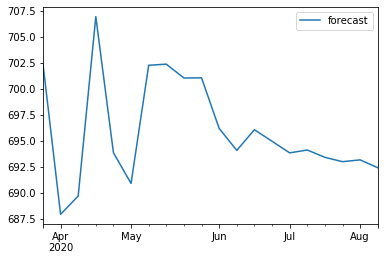

In [112]:
sample_forecasted.plot()

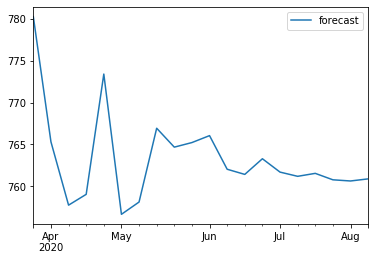

In [115]:
forecast.plot()

### The 2nd method seems to be working well. So code in kernels below uses the prediction from this method.
I have spliced the dataframe to get recent data(>=2019) and concatenated it with predicted value. If concatenation is not to done, there occurs discontinuity in the graph. This is because two different dataframes are plotted, terminating value of 1st and initiating value of 2nd dataframe doesn't coincide at a point resulting in discontinuity.

In [116]:
recent_data=data["2019":].copy()
recent_data.columns=['forecast']
recent_data.head()

,forecast
Date,
2019-01-06,847.8
2019-01-13,835.8
2019-01-20,843.4
2019-01-27,840.2
2019-02-03,836.6


## Discontinuous Graph

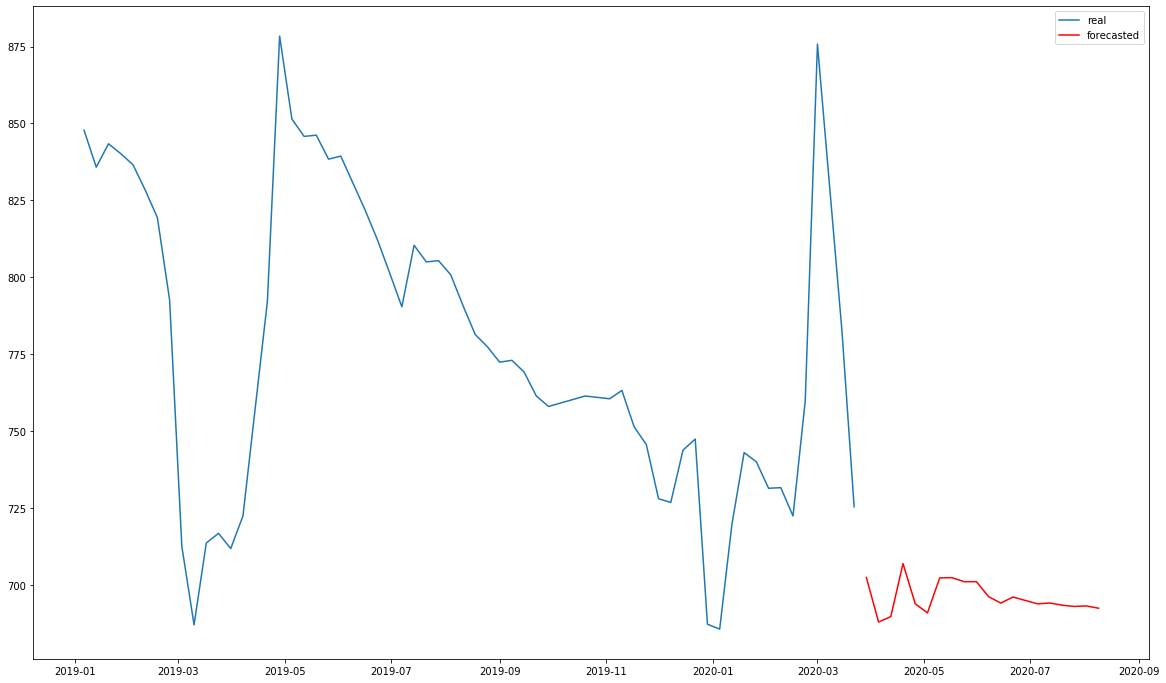

In [117]:
plt.figure(figsize=(20,12))
plt.plot(recent_data,label="real")
plt.plot(sample_forecasted,color='red',label='forecasted')
plt.legend()

In [118]:
collective_data=pd.concat([recent_data,sample_forecasted])
collective_data.head()

,forecast
2019-01-06,847.8
2019-01-13,835.8
2019-01-20,843.4
2019-01-27,840.2
2019-02-03,836.6


Text(2020-03-29 00:00:00, 720, 'Forecast begins here')

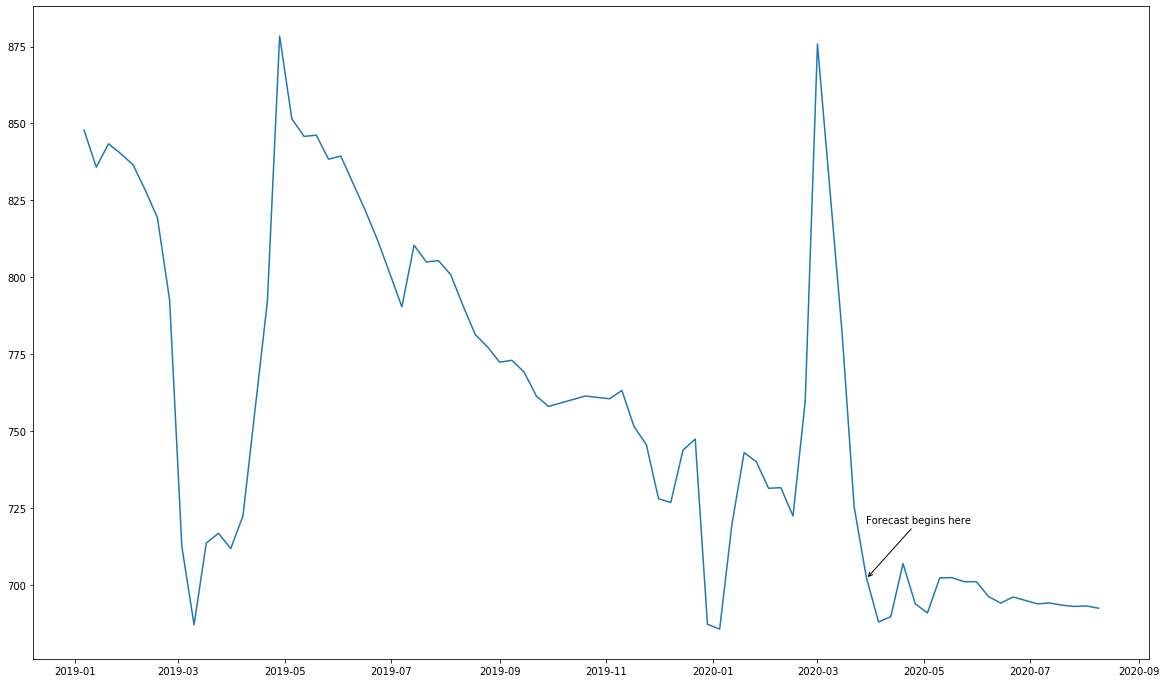

In [119]:
from datetime import datetime
plt.figure(figsize=(20,12))
plt.plot(collective_data)
plt.annotate("Forecast begins here",
             xy= (datetime(2020,3,29), 702),
             arrowprops=dict(arrowstyle="->"),
             xytext=(datetime(2020,3,29), 720))